# Analysis ver5

#### Modifed from ver4 to create final model used on web site.

In [1]:
%matplotlib inline

In [2]:
cd /home/tobiszuts/insight/project

/media/tobiszuts/Windows/Data/Work/Insight/project


In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data cleaning

Get the data and start processing.

In [4]:
file_load = "Reddit_depression.p"
results = pickle.load( open(file_load, 'rb'))

In [5]:
class SimpleTimer() :
    def __init__(self) :
        import time
        self.start_time = time.time()
        
    def elapsed(self, message = None) :
        import time
        if message :
            print("--- {:.2e} s ---   {}".format(time.time() - self.start_time, message) )
        else :
            print("--- {} s ---".format(time.time() - self.start_time) )  

## Create Features

In [6]:
def CreateFeatures1(raw_data, use_timer = False) :
    """ This processes the post data, and can be used as 
    a template for the upload data.
    """
    import pandas as pd
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    
    if use_timer :
        my_timer = SimpleTimer()
    
    # is this training data, or web app data?  If yes, process UTC code
    if len(raw_data.columns) > 10 : 
        # some of these columns aren't being used to create features yet
        extract_keys = ['num_comments', 'created_utc', 'title', 'selftext']
        data = raw_data[sorted(extract_keys)].copy()
    
        # remove all rows without any valid text
        data = data[data.selftext.map(len) > 0]
            
        dates = pd.to_datetime(data.created_utc, unit="s")
        data['created_dayofweek'] = dates.dt.dayofweek
        data['created_hour'] = dates.dt.hour
        data['created_month'] = dates.dt.month
        data['created_year'] = dates.dt.year
        cut_off_year = 2011
        data = data[ data.created_year > cut_off_year]
        print('Removing all posts before 2011. ', end='')
        print('Earliest post = {}'.format(pd.to_datetime(data.created_utc.min(), unit="s")))
        data = data.drop('created_utc', axis=1)
    else :
        data = raw_data
    
    data['post_char_len'] = data.selftext.apply(lambda x: len(x))
    data['post_num_qs'] = data.selftext.apply(lambda x: x.count('?'))
    data['title_char_len'] = data.title.apply(lambda x: len(x))
    data['title_num_qs'] = data.title.apply(lambda x: x.count('?'))
    
    data['post_word_len1'] = data.selftext.apply(lambda x: len(x.split()) )
    data['title_word_len1'] = data.title.apply(lambda x: len(x.split()) )
    
    if use_timer :
        my_timer.elapsed('Done with simple counts')
    
    def CountPostPunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['selftext'] :
            if char in punc_set :
                num_punc += 1
        return num_punc
    def CountTitlePunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['title'] :
            if char in punc_set :
                num_punc += 1
        return num_punc

    data['post_num_punc'] = data.apply(CountPostPunctuation, axis=1)
    data['title_num_punc'] = data.apply(CountTitlePunctuation, axis=1)
    data['post_perc_punc'] = data.post_num_punc / data.post_char_len
    data['title_perc_punc'] = data.title_num_punc / data.title_char_len
    data.post_perc_punc = data.post_perc_punc.fillna(0)
    
    if use_timer :
        my_timer.elapsed('Done with percentage counts')
    
    # Sentiment features
    sia_ps = SIA().polarity_scores
    
    posts_sent = []
    for post in data.selftext : 
        temp = sia_ps(post)
        posts_sent.append([temp[k] for k in sorted(temp.keys())])
            
    titles_sent = []
    for title in data.title :
        temp = sia_ps(title)
        titles_sent.append([temp[k] for k in sorted(temp.keys())])
    
    data['title_compound'] = [t[0] for t in titles_sent]
    data['title_neg'] = [t[1] for t in titles_sent]
    data['title_neu'] = [t[2] for t in titles_sent]
    data['title_pos'] = [t[3] for t in titles_sent]
    
    data['post_compound'] = [t[0] for t in posts_sent]
    data['post_neg'] = [t[1] for t in posts_sent]
    data['post_neu'] = [t[2] for t in posts_sent]
    data['post_pos'] = [t[3] for t in posts_sent]
       
    if use_timer :
        my_timer.elapsed('Done')
        
    return data

The following function takes about 270 seconds = 4.5 minutes to run on the whole data set.

In [7]:
data_raw = pd.DataFrame(results)
data_clean = CreateFeatures1(data_raw, use_timer=True)
print('There are {} posts after processing.'.format(len(data_clean)))
data_clean.head()

/home/tobiszuts/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Removing all posts before 2011. Earliest post = 2012-01-01 00:41:48
--- 1.90e+00 s ---   Done with simple counts
--- 7.97e+00 s ---   Done with percentage counts
--- 2.58e+02 s ---   Done
There are 73724 posts after processing.


,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,...,post_perc_punc,title_perc_punc,title_compound,title_neg,title_neu,title_pos,post_compound,post_neg,post_neu,post_pos
0,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1,42,...,0.045515,0.047619,0.3612,0.000,0.706,0.294,-0.9712,0.207,0.769,0.025
1,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5,72,...,0.054499,0.055556,-0.5216,0.206,0.794,0.000,0.9900,0.125,0.559,0.317
2,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0,40,...,0.032425,0.050000,0.0000,0.000,1.000,0.000,0.9226,0.152,0.630,0.218
3,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1,40,...,0.056380,0.025000,-0.5423,0.333,0.667,0.000,-0.7227,0.119,0.853,0.028
4,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0,16,...,0.000000,0.000000,-0.1779,0.362,0.638,0.000,-0.9501,0.308,0.539,0.153


In [8]:
temp = data_raw[data_raw.title=="I think about things too much...."]
print('Earliest post = {}'.format(pd.to_datetime(temp.created_utc.min(), unit="s")))

Earliest post = 2013-12-08 04:03:14


In [9]:
data_clean.columns

Index(['num_comments', 'selftext', 'title', 'created_dayofweek',
       'created_hour', 'created_month', 'created_year', 'post_char_len',
       'post_num_qs', 'title_char_len', 'title_num_qs', 'post_word_len1',
       'title_word_len1', 'post_num_punc', 'title_num_punc', 'post_perc_punc',
       'title_perc_punc', 'title_compound', 'title_neg', 'title_neu',
       'title_pos', 'post_compound', 'post_neg', 'post_neu', 'post_pos'],
      dtype='object')

# NLP pre-processing

Start the NLP processing.

In [245]:
data_clean2 = data_clean.copy()

In [234]:
data_clean2 = data_clean[:20000]

All functions down below

In [10]:
def ProcessText(raw_text) :
    """ Destem, tokenize, and remove stop words from texts.  Raw_text should
        be an array of documents.
    """
    from nltk.tokenize import WordPunctTokenizer
    import string
    from nltk.stem.snowball import SnowballStemmer
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    word_punct_tokenizer = WordPunctTokenizer()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)

    texts_proc = []
    for text in raw_text :
        words = word_punct_tokenizer.tokenize(text)
        words = [w for w in words if (w not in stop_words)]
        texts_proc.append([stemmer.stem(w.lower()) for w in words 
                                if not all(c in punctuation for c in w)])
    return texts_proc

In [11]:
def CreateCorpusDictionary(texts) :
    """ Create a from a tokenized text (an array of tokenized documents) 
        a corpus dictionary.
    """
    from gensim import corpora

    # create dictionary
    corpus_dictionary = corpora.Dictionary(texts)
    corpus_dictionary.filter_extremes(no_below=3, no_above=0.5)
    print(corpus_dictionary)
    return corpus_dictionary   

In [12]:
def Vectorize_text(texts, dictionary) :
    "From a list of tokenized texts, create their vectorized representation"
    return [dictionary.doc2bow(text) for text in texts]

In [13]:
def ComputeDocumentLSIs(documents, lsi, N, label_base = 'lsi') : 
    " Compute the LSI representation of every document in the corpus"
    baseline = [0 for x in range(N)]
    col_labels = ['{}_{}'.format(label_base, x) for x in range(N)]
    new_features = pd.DataFrame([], columns=col_labels)
    for (x, text) in enumerate(documents) :
        if len(text) > 0:
            lsi_temp = lsi[text]
            if len(lsi_temp) == N :
                temp = [y for (z,y) in lsi_temp]
                new_features.loc[x] = temp
            else :
                #print(x, len(temp))
                new_features.loc[x] = baseline
        else :
            new_features.loc[x] = baseline
    return new_features

In [14]:
def NLP_process(df, dictionary = None, post_lsi = None, title_lsi = None, num_lsi_topics = None, use_timer = True) :
    """ Function for NLP pre-processing.  If dictionary isn't specified, 
        create it from the posts and titles.  If post_lsi and title_lsi are not
        specified, create them as well.
    """
    from gensim.models import lsimodel
    
    if use_timer :
        my_timer = SimpleTimer()
    posts_tokenized = ProcessText(df.selftext)
#    posts_tokenized = []
    if use_timer :
        my_timer.elapsed('Processed Posts')
    
    titles_tokenized = ProcessText(df.title)
    if use_timer :
        my_timer.elapsed('Processed Titles')
    
    if not dictionary :
        dictionary = CreateCorpusDictionary(posts_tokenized + titles_tokenized)
        if use_timer :
            my_timer.elapsed('Created Dictionary')
        
    posts_vec = Vectorize_text(posts_tokenized, dictionary)
    titles_vec = Vectorize_text(titles_tokenized, dictionary)
    print(len(titles_vec), df.shape)
    df_new = df.copy()
    df_new = df_new.assign(post_word_len2 = [len(post) for post in posts_vec] )
    df_new = df_new.assign(title_word_len2 = [len(post) for post in titles_vec] )
    
    df_new = df_new[sorted(df_new.columns)]
    
    if use_timer :
        my_timer.elapsed('Vectorized')

    if not post_lsi :
        post_lsi = lsimodel.LsiModel(posts_vec, num_topics = num_lsi_topics, id2word = dictionary)
    if not title_lsi :
        title_lsi = lsimodel.LsiModel(titles_vec, num_topics = num_lsi_topics, id2word = dictionary)
        my_timer.elapsed('Trained LSI')
        
    post_lsi_features = ComputeDocumentLSIs(posts_vec, post_lsi, num_lsi_topics, label_base = 'post_lsi')
    if use_timer :
        my_timer.elapsed('Computed Post LSIs')
    title_lsi_features = ComputeDocumentLSIs(titles_vec, title_lsi, num_lsi_topics, label_base = 'title_lsi')
    if use_timer :
        my_timer.elapsed('Computed Title LSIs')
    
    post_lsi_features = post_lsi_features.set_index(df_new.index)
    title_lsi_features = title_lsi_features.set_index(df_new.index)
    
    df_new = df_new.join(post_lsi_features)
    df_new = df_new.join(title_lsi_features)
    df_new = df_new.drop(['selftext', 'title'], axis=1)
    
    if use_timer :
        my_timer.elapsed('Completed {} records'.format(len(df_new)))

    return (df_new, dictionary, post_lsi, title_lsi)

In [246]:
(data_clean3, dictionary, post_lsi, title_lsi) = NLP_process(data_clean2, num_lsi_topics = 50 )

--- 1.70e+02 s ---   Processed Posts
--- 1.76e+02 s ---   Processed Titles
Dictionary(19524 unique tokens: ['think', 'straight', 'concentr', 'feel', 'like']...)
--- 1.88e+02 s ---   Created Dictionary
73724 (73724, 25)
--- 1.97e+02 s ---   Vectorized
--- 2.06e+02 s ---   Trained LSI
--- 6.35e+02 s ---   Computed Post LSIs
--- 1.03e+03 s ---   Computed Title LSIs
--- 1.03e+03 s ---   Completed 73724 records


In [271]:
data_clean3.shape

(73724, 125)

In [19]:
'selftext' in data_clean3.columns

False

Save results to disk.

In [20]:
def SaveProcessingVariables(base_name, num_lsi_topics, post_lsi, title_lsi, dictionary, comment_bins) :
    "function to store all processing variables in separate files"
    
    file_name = '{}_num_lsi_topics.p'.format(base_name)
    pickle.dump(num_lsi_topics, open(file_name, 'wb'))
    
    file_name = '{}_post_lsi.p'.format(base_name)
    pickle.dump(post_lsi, open(file_name, 'wb'))
    
    file_name = '{}_title_lsi.p'.format(base_name)
    pickle.dump(title_lsi, open(file_name, 'wb'))
    
    file_name = '{}_dictionary.p'.format(base_name)
    pickle.dump(dictionary, open(file_name, 'wb'))
    
    file_name = '{}_comment_bins.p'.format(base_name)
    pickle.dump(comment_bins, open(file_name, 'wb'))
    
    return

In [535]:
comment_bins

[-1, 2.5, 1000]

In [536]:
SaveProcessingVariables('Model_2bins_all', post_lsi.num_topics, post_lsi, title_lsi, dictionary, comment_bins)

In [15]:
import pickle
load_flag = 1 
if load_flag :
    data_clean2 = pickle.load(open('Model_2bins_all_dataframe.p', 'rb'))
else :
    pickle.dump(data_clean3, open('Model_2bins_all_dataframe.p', 'wb'))

In [17]:
data_clean2.head()

,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_compound,post_neg,post_neu,post_num_punc,post_num_qs,...,title_lsi_41,title_lsi_42,title_lsi_43,title_lsi_44,title_lsi_45,title_lsi_46,title_lsi_47,title_lsi_48,title_lsi_49,comment_category
0,4,14,2,2014,747,-0.9712,0.207,0.769,34,1,...,0.078495,-0.028016,0.014054,0.022921,0.001884,0.086915,-0.015976,-0.000154,0.086122,0
1,4,14,2,2014,789,0.9900,0.125,0.559,43,5,...,0.063834,0.099578,-0.035766,0.097336,-0.136106,0.300351,0.883008,-0.283018,-0.230924,0
2,4,14,2,2014,771,0.9226,0.152,0.630,25,0,...,0.056934,0.007311,-0.041631,0.004888,-0.042907,-0.296603,0.043895,0.050030,-0.061544,0
3,4,13,2,2014,337,-0.7227,0.119,0.853,19,1,...,0.001552,-0.013923,0.011469,0.046968,-0.041790,-0.009816,-0.014312,0.089174,-0.025639,0
4,4,12,2,2014,671,-0.9501,0.308,0.539,0,0,...,-0.000336,0.002600,0.003977,-0.003235,-0.015715,-0.001090,-0.004003,0.001168,0.004642,0


In [22]:
print(data_clean.selftext[data_clean.title=="I think about things too much...."].values)

[ "I've been thinking so much about life lately, and I just feel like what's the point of making a life for yourself when you will not make a true difference in the world? In the grand scheme of the universe, we represent far less than one percent. We are the greatest beings known to us and yet we find the most retarded reasons to fight over. We put down our brother and sisters because they are different in who they decide to love. Even the belief of spiritual beings or lack thereof. We are all human beings. We should all be equal and together in love and happiness. All this thinking is making me really depressed and I'm scared. I've considered suicide before but I will never actually do it.\n\nI am not going to get started on my personal things that also make me depressed. That's a whole nother story..."]


# Classification Model

In [274]:
def BinNumComments(df, bins) :
    """ Bin the number of comments into the specified number of bins
    """
    import pandas as pd
    df_new = df.copy()
    categorized = pd.cut(df_new.num_comments, bins=bins, labels = False, include_lowest = True)
    df_new = df_new.assign(comment_category=categorized)
       
    return df_new.drop('num_comments', axis=1)

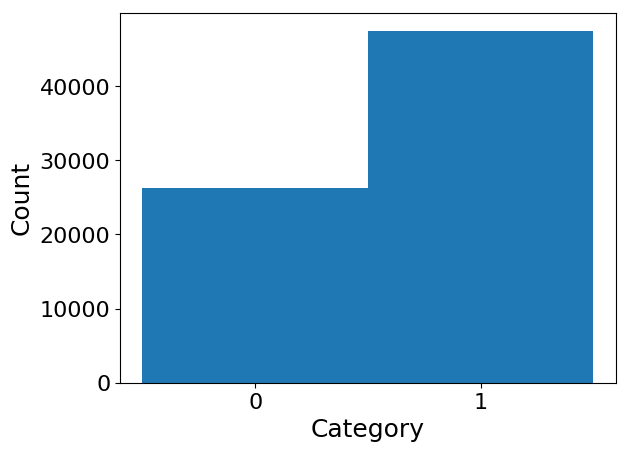

In [304]:
comment_bins = [0, 1, 1000]
data_binned_2a = BinNumComments(data_clean3, comment_bins)
plt.hist(data_binned_2a.comment_category, bins=range(len(comment_bins)), align='left')
plt.xticks(np.arange(0, len(comment_bins)-1, 1))
plt.xlabel('Category')
plt.ylabel('Count')

In [275]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [278]:
list(range(len(comment_bins)))

[0, 1, 2]

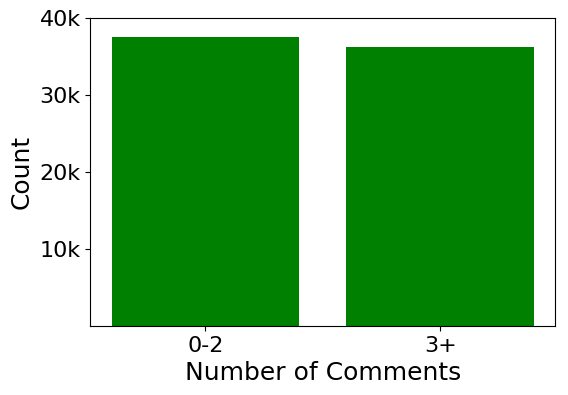

In [336]:
comment_bins = [0, 2, 1000]
data_binned_2b = BinNumComments(data_clean3, comment_bins)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.hist(data_binned_2b.comment_category, bins=range(len(comment_bins)), 
         align='left', rwidth=0.8, color="#008000")
plt.xticks(np.arange(0, len(comment_bins)-1, 1))
plt.xlabel('Number of Comments')
plt.ylabel('Count')
ax.set_xticklabels(['0-2', '3+'])
ax.set_yticks([x*10000 for x in range(4, 0, -1)])
ax.set_yticklabels(['40k', '30k', '20k', '10k', '0'])

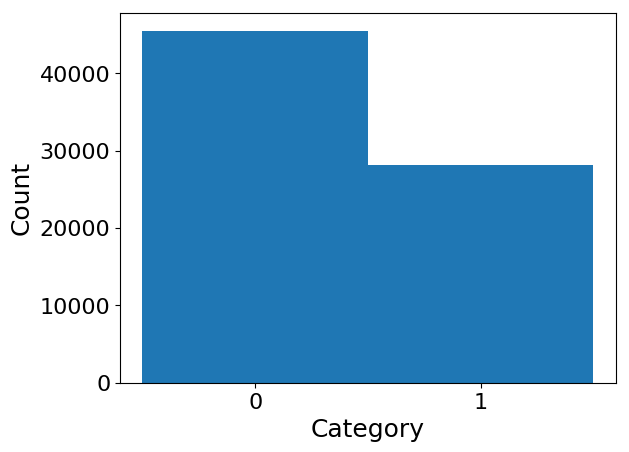

In [338]:
comment_bins = [0, 3, 1000]
data_binned_2c = BinNumComments(data_clean3, comment_bins)
plt.hist(data_binned_2c.comment_category, bins=range(len(comment_bins)), align='left')
plt.xticks(np.arange(0, len(comment_bins)-1, 1))
plt.xlabel('Category')
plt.ylabel('Count')

# Process a single post

In [28]:
def ProcessPost(post_title, post_text, post_time) :
    """ Process a single post from the web app.
    """
    import time
    import pandas as pd
    
    date = time.strptime(post_time, r"%Y-%m-%d %H:%M:%S")
    data = pd.DataFrame({
        'title': post_title, 
        'selftext': post_text, 
        'created_dayofweek': date.tm_wday,
        'created_hour': date.tm_hour,
        'created_month': date.tm_mon,
        'created_year': 2014,
        }, index=[0])

    
    data = CreateFeatures1(data)
    # def NLP_process(df, dictionary = None, post_lsi = None, title_lsi = None, num_lsi_topics = None, use_timer = True) :

    (data, del1, del2, del3) = NLP_process(data, dictionary, post_lsi, title_lsi, post_lsi.num_topics, use_timer = False )
    return data

In [29]:
ProcessPost('Test title', 'This is the bulk of the post, just nonsense for now.', '2017-09-26 09:47:28')

1 (1, 24)


,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_compound,post_neg,post_neu,post_num_punc,post_num_qs,...,title_lsi_190,title_lsi_191,title_lsi_192,title_lsi_193,title_lsi_194,title_lsi_195,title_lsi_196,title_lsi_197,title_lsi_198,title_lsi_199
0,1,9,9,2014,52,-0.4019,0.213,0.787,2,0,...,-0.023529,-0.014526,0.005082,-0.01205,-0.028859,0.00676,0.05628,-0.028353,-0.006283,-0.050761


## Train Model

In [449]:
from sklearn import ensemble, linear_model

class BuildClassificationModel() :
    
    def __init__(self, data, model_type = 'randomforest', test_frac = 0.2, fit_flag = True) :
        from sklearn import ensemble, linear_model
        from sklearn.model_selection import train_test_split
        from sklearn.svm import SVC
       
        data_x = data.drop('comment_category', axis=1)
        data_y = data.comment_category
        
        (self.train_x, self.test_x, self.train_y, self.test_y) = train_test_split(
                    data_x, data_y, test_size = test_frac)
                
        if model_type == 'randomforest' :
            self.model = ensemble.RandomForestClassifier()
        elif model_type == 'gradientboostingclassifier' :
            self.model = ensemble.GradientBoostingClassifier()
        elif model_type == 'logisticregression' :
            self.model = linear_model.LogisticRegression()
        elif model_type == 'svc' :
            self.model = SVC(kernel='rbf', C=1e3, gamma=0.1)
        else :
            print('Model type "{}" is not defined'.format(model_type))
            return
        
        if fit_flag :
            print('{} on {} features.  Training on {} rows, validating on {}.'.format(model_type, self.train_x.shape[1], self.train_x.shape[0], self.test_x.shape[0]))
            self.model.fit(self.train_x, self.train_y)
        return
    
    def predict(self) :
        from sklearn import metrics
        predict_y = self.model.predict(self.test_x)
        print('Accuracy: %.3f' % self.model.score(self.test_x, self.test_y))
        print('Precision: %.3f' % metrics.precision_score(self.test_y, predict_y))
        print('Recall score: %.3f' % metrics.recall_score(self.test_y, predict_y))
        print('F1 score: %.3f' % metrics.f1_score(self.test_y, predict_y))
        

    def confusion_matrix(self, bins=None) :
        from sklearn.metrics import confusion_matrix
        cnf_matrix = confusion_matrix(self.test_y, 
            self.model.predict(self.test_x))
        plt.figure()
        if bins :
            plot_confusion_matrix(cnf_matrix, classes=bins, normalize=True)
        else :
            plot_confusion_matrix(cnf_matrix, normalize=True)
        
def TestClassificationModels(train_x, train_y, models_to_test, log_flag = False, bins = None) :
    "Train model on the models supplied in models_to_test"
    models = []
    for model in models_to_test :
        model_temp = BuildClassificationModel(train_x, train_y, model_type = model)
        model_temp.predict()
        models.append(model_temp)
        model_temp.confusion_matrix(bins=bins)
        print()
    return models

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True # Comments')
    plt.xlabel('Predicted # Comments')

In [31]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [32]:
from scipy.stats import randint as sp_randint
# specify parameters and distributions to sample from
param_dist_rf = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "class_weight": ['balanced', 'balanced_subsample', None],
              "n_estimators": [10, 15, 20],
             }

# Analyze models

randomforest on 124 features.  Training on 58979 rows, validating on 14745.
Accuracy: 0.588
Precision: 0.672
Recall score: 0.713
F1 score: 0.692
Normalized confusion matrix
[[ 0.35578784  0.64421216]
 [ 0.28708633  0.71291367]]


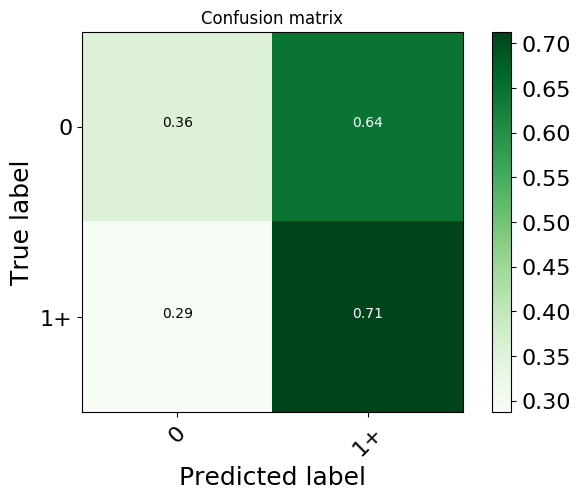

In [346]:
model_binned_2a_ranfor = BuildClassificationModel(data_binned_2a, 'randomforest')
model_binned_2a_ranfor.predict()

curr_bins = ['0', '1+']
model_binned_2a_ranfor.confusion_matrix(curr_bins)

In [340]:
model_binned_2b_ranfor = BuildClassificationModel(data_binned_2b, 'randomforest')
model_binned_2b_ranfor.predict()

randomforest on 124 features.  Training on 58979 rows, validating on 14745.
Accuracy: 0.533
Precision: 0.526
Recall score: 0.401
F1 score: 0.455


Highly overfitting to the data!

In [341]:
model_binned_2b_ranfor.model.score(model_binned_2b_ranfor.train_x, model_binned_2b_ranfor.train_y)

0.98635107411112433

Normalized confusion matrix
[[ 0.65772078  0.34227922]
 [ 0.59922016  0.40077984]]


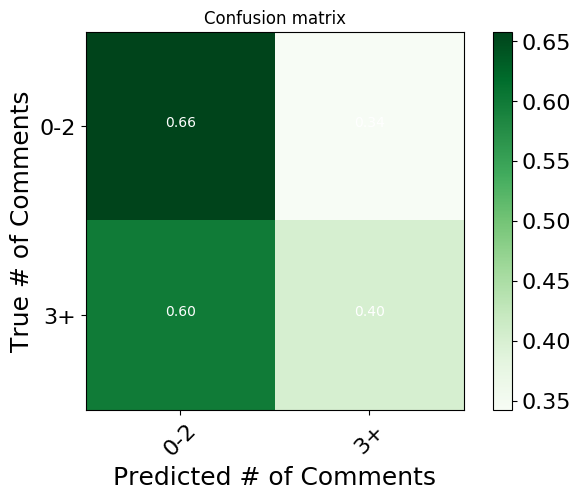

In [349]:
curr_bins = ['0-2', '3+']
model_binned_2b_ranfor.confusion_matrix(curr_bins)
plt.xlabel('Predicted # of Comments')
plt.ylabel('True # of Comments')

randomforest on 124 features.  Training on 58979 rows, validating on 14745.
Accuracy: 0.535
Precision: 0.539
Recall score: 0.396
F1 score: 0.456
Normalized confusion matrix
[[ 0.67094531  0.32905469]
 [ 0.60418387  0.39581613]]


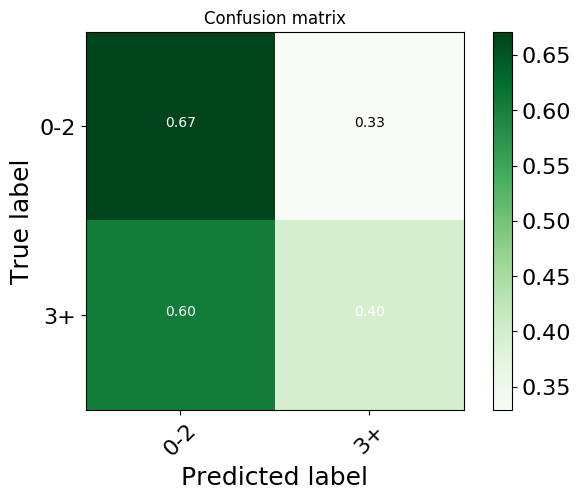

In [351]:
model_binned_2b_ranfor = BuildClassificationModel(data_binned_2b, 'randomforest')
model_binned_2b_ranfor.predict()

curr_bins = ['0-2', '3+']
model_binned_2b_ranfor.confusion_matrix(curr_bins)

randomforest on 124 features.  Training on 58979 rows, validating on 14745.
Accuracy: 0.542
Precision: 0.546
Recall score: 0.412
F1 score: 0.469
Normalized confusion matrix
[[ 0.66826859  0.33173141]
 [ 0.58836504  0.41163496]]


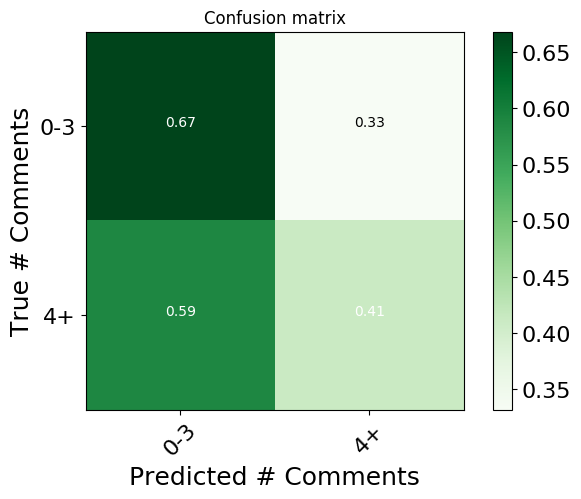

In [462]:
model_binned_2c_ranfor = BuildClassificationModel(data_binned_2c, 'randomforest')
model_binned_2c_ranfor.predict()

curr_bins = ['0-3', '4+']
model_binned_2c_ranfor.confusion_matrix(curr_bins)

In [586]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0.25, vmax=0.75))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize=24,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True # Comments')
    plt.xlabel('Predicted # Comments')

Normalized confusion matrix
[[ 0.66826859  0.33173141]
 [ 0.58836504  0.41163496]]


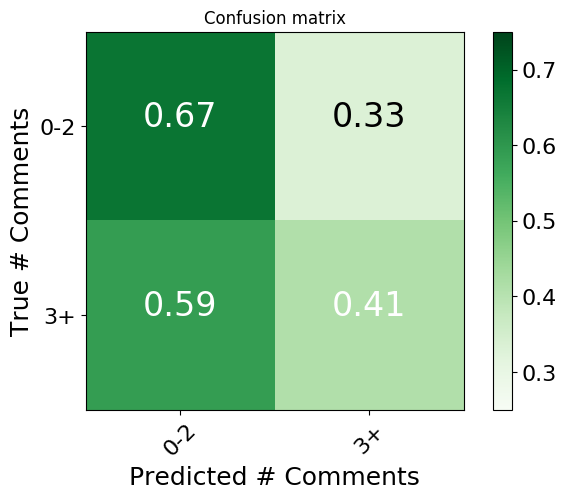

In [587]:
curr_bins = ['0-2', '3+']
model_binned_2c_ranfor.confusion_matrix(curr_bins)

In [353]:
file_name = 'Model_2bins_model.p'
pickle.dump(model_binned_2c_ranfor.model, open(file_name, 'wb'))

In [354]:
data_binned_2b.shape

(73724, 125)

In [210]:
data_x = data_binned_2b.drop('comment_category', axis=1)
data_y = data_binned_2b.comment_category
(train_x, test_x, train_y, test_y) = train_test_split(data_x, data_y, test_size = 0.1)

The following done with 200 LSA features and 20k posts.

In [218]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
model_2b = BuildClassificationModel(data_binned_2b, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_2b.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 112.48 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.562 (std: 0.007)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.555 (std: 0.008)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 15}

Model with rank: 3
Mean validation score: 0.554 (std: 0.007)
Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 20}



The following done with 50 LSA features and 20k posts.

In [241]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
model_2b = BuildClassificationModel(data_binned_2b, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_2b.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 68.52 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.562 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 15}

Model with rank: 2
Mean validation score: 0.562 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.556 (std: 0.005)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 20}



In [365]:
data_binned_2c.shape

(73724, 125)

In [366]:
data_x = data_binned_2c.drop('comment_category', axis=1)
data_y = data_binned_2c.comment_category
(train_x, test_x, train_y, test_y) = train_test_split(data_x, data_y, test_size = 0.1)

model_2c = BuildClassificationModel(data_binned_2c, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_2c.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 244.36 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.619 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 15}

Model with rank: 2
Mean validation score: 0.619 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.619 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.619 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2, '

In [360]:
param_dist_rf

{'bootstrap': [True, False],
 'class_weight': ['balanced', 'balanced_subsample', None],
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, None],
 'max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f07ca3fb780>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f07ca3fd240>,
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f07ca3fd0b8>,
 'n_estimators': [10, 15, 20]}

In [361]:
def predict(model, test_x, test_y) :
    from sklearn import metrics
    predict_y = model.predict(test_x)
    print('Accuracy: %.3f' % model.score(test_x, test_y))
    print('Precision: %.3f' % metrics.precision_score(test_y, predict_y))
    print('Recall score: %.3f' % metrics.recall_score(test_y, predict_y))
    print('F1 score: %.3f' % metrics.f1_score(test_y, predict_y))

In [368]:
data_x = data_binned_2c.drop('comment_category', axis=1)
data_y = data_binned_2c.comment_category
(train_x, test_x, train_y, test_y) = train_test_split(data_x, data_y, test_size = 0.1)

In [369]:
model_2c_best = random_search.best_estimator_
#model_2b_best.fit(train_x, train_y)
predict(model_2c_best, test_x, test_y)

Accuracy: 0.616
Precision: 0.000
Recall score: 0.000
F1 score: 0.000


/home/tobiszuts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tobiszuts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [217]:
model_2b_best

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


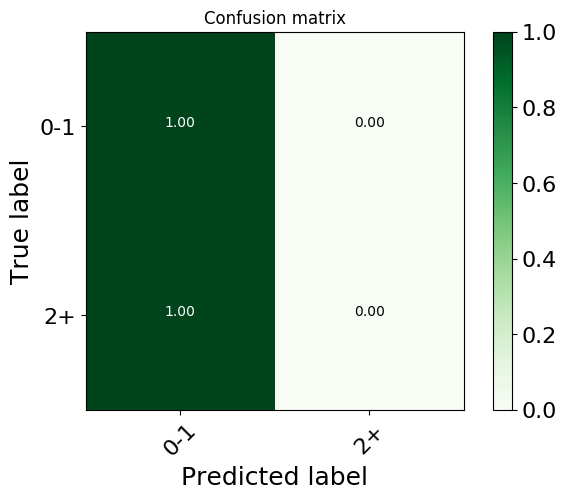

In [370]:
cnf_matrix = confusion_matrix(test_y, model_2c_best.predict(test_x))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=comment_bin_labels, normalize=True, cmap=plt.cm.Greens)

In [42]:
from sklearn import ensemble, linear_model
from sklearn.model_selection import train_test_split

data_x = data_binned_2b.drop('comment_category', axis=1)
data_y = data_binned_2b.comment_category
(train_x, test_x, train_y, test_y) = train_test_split(data_x, data_y, test_size = 0.1)
               
best_parameters = {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 15}
best_parameters = {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 15}

model_2b_ranfor_best = ensemble.RandomForestClassifier()#**best_parameters)
#model_2b_ranfor_best = random_search.best_estimator_
model_2b_ranfor_best.fit(train_x, train_y)

predict(model_2b_ranfor_best, test_x, test_y)

Accuracy: 0.555
Precision: 0.488
Recall score: 0.284
F1 score: 0.359


Normalized confusion matrix
[[ 0.97855228  0.02144772]
 [ 0.0953462   0.9046538 ]]


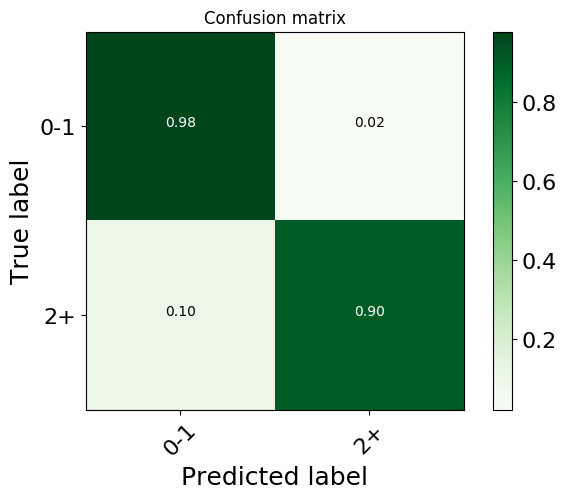

In [247]:
from sklearn.metrics import confusion_matrix
comment_bin_labels = ['0-1', '2+']
cnf_matrix = confusion_matrix(test_y, model_2b_ranfor_best.predict(test_x))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=comment_bin_labels, normalize=True, cmap=plt.cm.Greens)

# Best fit, everything together

That is to say, ignore what's above as incomplete and potentially inaccurate.

In [414]:
def RandomForest_bestFit(data, param_distributions, bins = None) :
    """ Given a dataframe with x and y data, split into data, run randomized
        grid search, and plot accuracy and confunsion matrix for best fit.
    """
    from sklearn import ensemble, linear_model
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import RandomizedSearchCV
    from time import time
    
    data_x = data.drop('comment_category', axis=1)
    data_y = data.comment_category
    (train_x, test_x, train_y, test_y) = train_test_split(
                data_x, data_y, test_size = 0.2)

    model = ensemble.RandomForestClassifier()
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions=param_dist_rf, n_iter=n_iter_search)

    start = time()
    random_search.fit(train_x, train_y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)

    model_best = random_search.best_estimator_
    
    from sklearn import metrics
    predict_y = model_best.predict(test_x)
    print('Accuracy: %.3f' % model_best.score(test_x, test_y))
    print('Precision: %.3f' % metrics.precision_score(test_y, predict_y))
    print('Recall score: %.3f' % metrics.recall_score(test_y, predict_y))
    print('F1 score: %.3f' % metrics.f1_score(test_y, predict_y))


    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(test_y, model_best.predict(test_x))
    plt.figure()
    if bins :
        plot_confusion_matrix(cnf_matrix, classes=bins, normalize=True)
    else :
        plot_confusion_matrix(cnf_matrix, normalize=True)
    
    return model_best

RandomizedSearchCV took 250.82 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.831 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.831 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.830 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 7, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.830 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf'

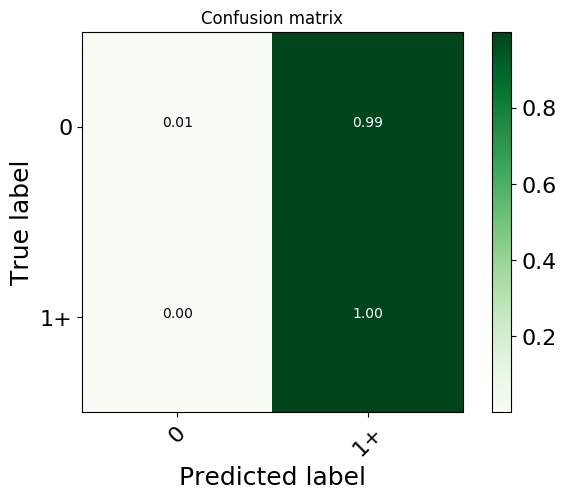

In [388]:
comment_bins = [-1, 0.5, 1000]
data_binned_2a = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0', '1+']
RandomForest_bestFit(data_binned_2a, param_dist_rf, bins = curr_bins)

RandomizedSearchCV took 222.63 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.645 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 10}

Model with rank: 1
Mean validation score: 0.645 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 15}

Model with rank: 3
Mean validation score: 0.641 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 20}

Accuracy: 0.643
Precision: 0.643
Recall score: 1.000
F1 score: 0.782
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


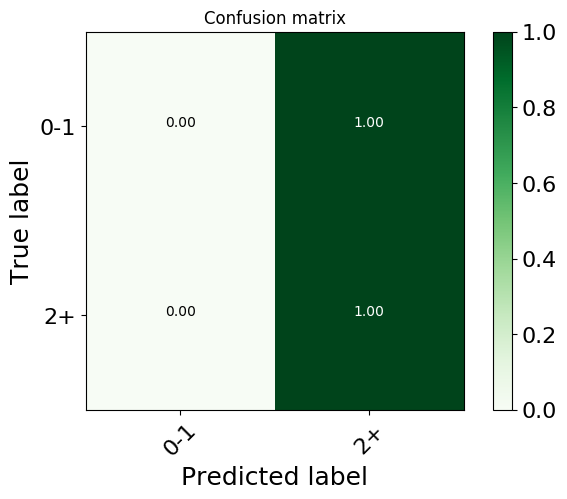

In [392]:
comment_bins = [-1, 1.5, 1000]
data_binned_2b = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0-1', '2+']
RandomForest_bestFit(data_binned_2b, param_dist_rf, bins = curr_bins)

In [409]:
data_binned_temp.comment_category.value_counts()

0    37508
1    36216
Name: comment_category, dtype: int64

In [407]:
len(data_clean3[data_clean3.num_comments<2.5])

37508

RandomizedSearchCV took 262.14 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.562 (std: 0.005)
Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.562 (std: 0.004)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 15}

Model with rank: 3
Mean validation score: 0.561 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}

Accuracy: 0.570
Precision: 0.569
Recall score: 0.553
F1 score: 0.561
Normalized confusion matrix
[[ 0.5864996   0.4135004 ]
 [ 0.44708453  0.55291547]]


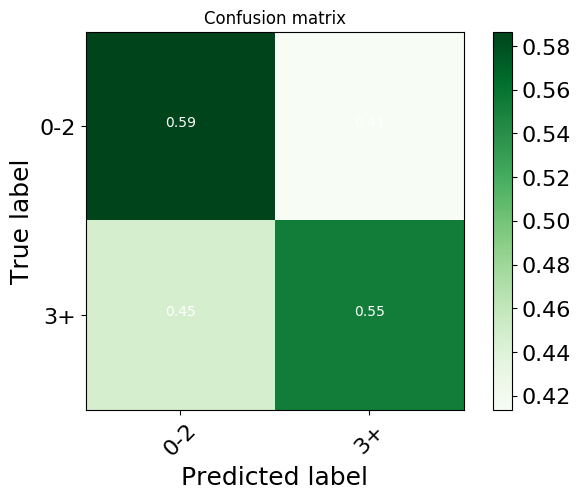

In [410]:
comment_bins = [0, 2, 1000]
data_binned_temp = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0-2', '3+']
RandomForest_bestFit(data_binned_temp, param_dist_rf, bins = curr_bins)

RandomizedSearchCV took 204.57 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.562 (std: 0.003)
Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.562 (std: 0.002)
Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.559 (std: 0.002)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 20}

Accuracy: 0.557
Precision: 0.550
Recall score: 0.520
F1 score: 0.535
Normalized confusion matrix
[[ 0.59357579  0.40642421]
 [ 0.48023852  0.51976148]]


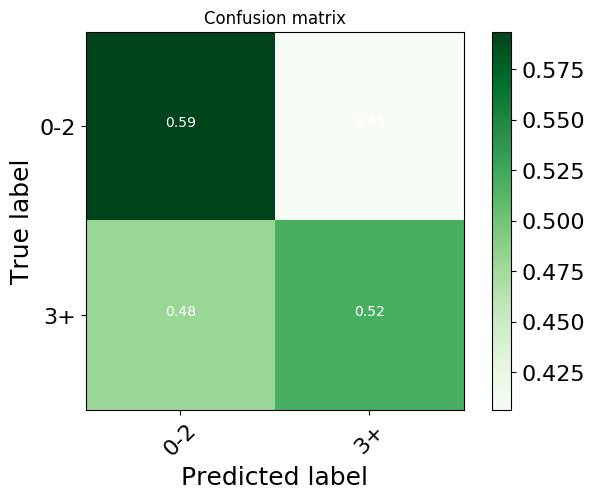

In [411]:
comment_bins = [-1, 2, 1000]
data_binned_temp = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0-2', '3+']
RandomForest_bestFit(data_binned_temp, param_dist_rf, bins = curr_bins)

RandomizedSearchCV took 202.91 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.563 (std: 0.003)
Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.562 (std: 0.002)
Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 15}

Model with rank: 3
Mean validation score: 0.561 (std: 0.001)
Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 20}

Accuracy: 0.565
Precision: 0.558
Recall score: 0.548
F1 score: 0.553
Normalized confusion matrix
[[ 0.58060218  0.41939782]
 [ 0.45158171  0.54841829]]


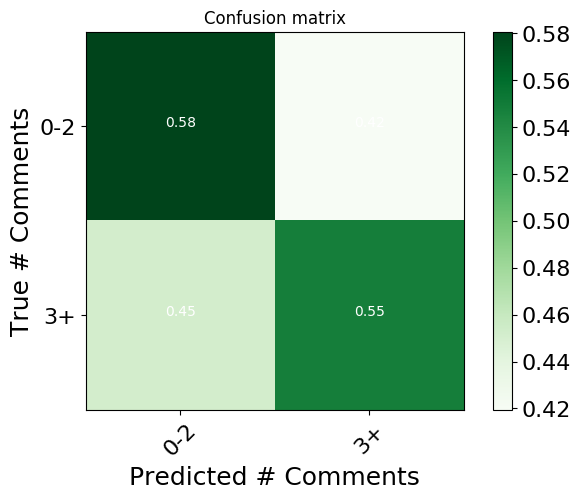

In [450]:
comment_bins = [-1, 2.5, 1000]
data_binned_2c = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0-2', '3+']
model_2c = RandomForest_bestFit(data_binned_2c, param_dist_rf, bins = curr_bins)

In [538]:
import pickle
pickle.dump(model_2c, open('Model_2bins_all_model.p', 'wb'))
pickle.dump(data_binned_2c, open('Model_2bins_all_dataframe.p', 'wb'))

In [399]:
data_clean3[data_clean3.num_comments>3].shape

(28213, 125)

RandomizedSearchCV took 223.60 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.618 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.618 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 15}

Model with rank: 2
Mean validation score: 0.618 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15}

Model with rank: 2
Mean validation score: 0.618 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 5, 'mi

/home/tobiszuts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tobiszuts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


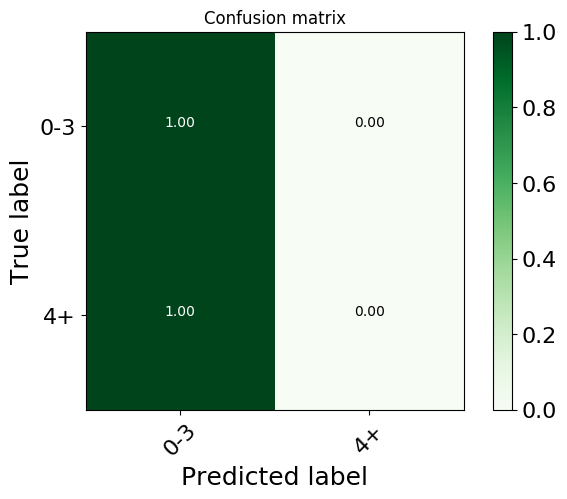

In [394]:
comment_bins = [-1, 3.5, 1000]
data_binned_2d = BinNumComments(data_clean3, comment_bins)
curr_bins = ['0-3', '4+']
RandomForest_bestFit(data_binned_2d, param_dist_rf, bins = curr_bins)

In [416]:
feature_importance = model_2c.feature_importances_
feature_importance_all = zip(range(len(feature_importance)), data_binned_2c.columns, feature_importance)
feature_importance_all = sorted(feature_importance_all, key=lambda x: x[2], reverse=True)[:18]
for (x, y, z) in  feature_importance_all:
    print('{}  {} \t {:.2}'.format(x, y, z))

3  created_year 	 0.11
12  post_word_len1 	 0.087
4  post_char_len 	 0.072
13  post_word_len2 	 0.068
14  title_char_len 	 0.055
1  created_hour 	 0.044
25  post_lsi_1 	 0.041
20  title_perc_punc 	 0.037
24  post_lsi_0 	 0.034
109  title_lsi_35 	 0.033
110  title_lsi_36 	 0.032
19  title_num_qs 	 0.028
23  title_word_len2 	 0.024
22  title_word_len1 	 0.021
96  title_lsi_22 	 0.019
29  post_lsi_5 	 0.015
8  post_num_punc 	 0.015
17  title_neu 	 0.015


In [422]:
feature_importance = model_2c_best.feature_importances_
feature_importance_all = zip(range(len(feature_importance)), data_binned_2c.columns, feature_importance)
feature_importance_all = sorted(feature_importance_all, key=lambda x: x[2], reverse=True)[:18]
for (x, y, z) in  feature_importance_all:
    print('{}  {} \t {:.2}'.format(x, y, z))

3  created_year 	 0.17
81  title_lsi_7 	 0.061
22  title_word_len1 	 0.054
20  title_perc_punc 	 0.053
23  title_word_len2 	 0.051
14  title_char_len 	 0.05
29  post_lsi_5 	 0.042
1  created_hour 	 0.038
25  post_lsi_1 	 0.032
4  post_char_len 	 0.031
24  post_lsi_0 	 0.03
19  title_num_qs 	 0.028
16  title_neg 	 0.027
13  post_word_len2 	 0.022
79  title_lsi_5 	 0.021
28  post_lsi_4 	 0.02
12  post_word_len1 	 0.02
31  post_lsi_7 	 0.019


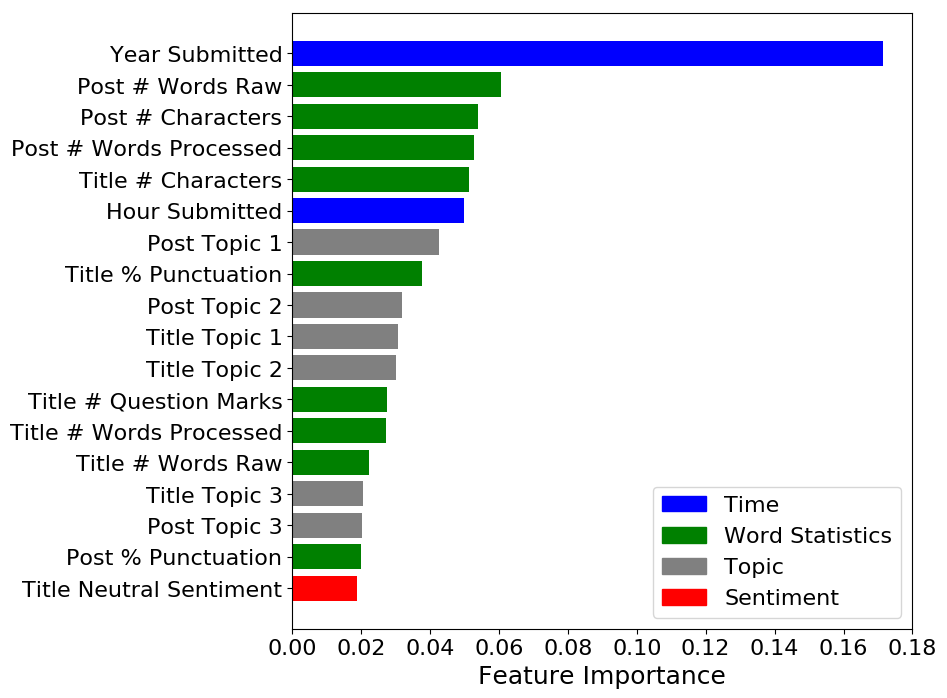

In [439]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize = (8,8))
y_pos = range(len(feature_importance_all), 0, -1)
labels = ['Year Submitted', 'Post # Words Raw', 'Post # Characters', 'Post # Words Processed',
          'Title # Characters', 'Hour Submitted', 'Post Topic 1', 'Title % Punctuation', 
          'Post Topic 2', 'Title Topic 1', 'Title Topic 2', 'Title # Question Marks', 
          'Title # Words Processed', 'Title # Words Raw', 'Title Topic 3', 'Post Topic 3', 
          'Post % Punctuation', 'Title Neutral Sentiment']
colors = ['b'] + ['g']*4 + ['b', 'grey', 'g'] + ['grey']*3 + ['g']*3 + ['grey']*2 + ['g', 'r']  
plt.barh(y_pos, [x[2] for x in feature_importance_all], color=colors)
#ax.set_yticklabels( [x[1] for x in feature_importance_all])
ax.set_yticklabels( labels)
ax.set_yticks(y_pos)
ax.set_xlabel('Feature Importance')
blue_patch = mpatches.Patch(color='blue', label='Time')
green_patch = mpatches.Patch(color='green', label='Word Statistics')
grey_patch = mpatches.Patch(color='grey', label='Topic')
red_patch = mpatches.Patch(color='red', label='Sentiment')

plt.legend(handles=[blue_patch, green_patch, grey_patch, red_patch], fontsize=16)


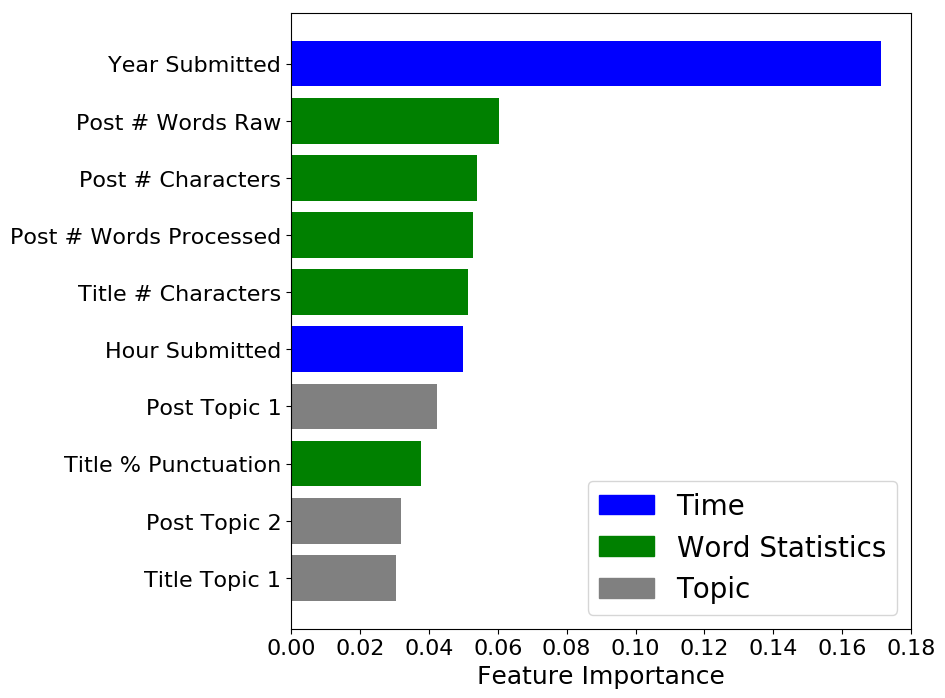

In [447]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize = (8,8))
y_pos = range(len(feature_importance_all[:10]), 0, -1)
labels = ['Year Submitted', 'Post # Words Raw', 'Post # Characters', 'Post # Words Processed',
          'Title # Characters', 'Hour Submitted', 'Post Topic 1', 'Title % Punctuation', 
          'Post Topic 2', 'Title Topic 1', 'Title Topic 2', 'Title # Question Marks', 
          'Title # Words Processed', 'Title # Words Raw', 'Title Topic 3', 'Post Topic 3', 
          'Post % Punctuation', 'Title Neutral Sentiment']
colors = ['b'] + ['g']*4 + ['b', 'grey', 'g'] + ['grey']*3 + ['g']*3 + ['grey']*2 + ['g', 'r']  
colors = colors[:10]
labels = labels[:10]
plt.barh(y_pos, [x[2] for x in feature_importance_all[:10]], color=colors)
#ax.set_yticklabels( [x[1] for x in feature_importance_all])
ax.set_yticklabels( labels)
ax.set_yticks(y_pos)
ax.set_xlabel('Feature Importance')
blue_patch = mpatches.Patch(color='blue', label='Time')
green_patch = mpatches.Patch(color='green', label='Word Statistics')
grey_patch = mpatches.Patch(color='grey', label='Topic')
red_patch = mpatches.Patch(color='red', label='Sentiment')

plt.legend(handles=[blue_patch, green_patch, grey_patch], fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07850047b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0784675668>]], dtype=object)

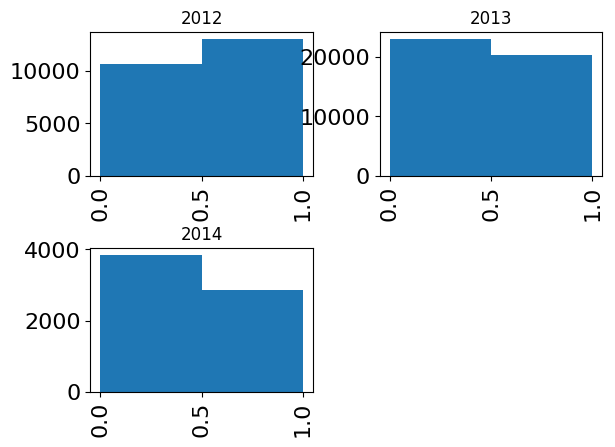

In [475]:
data_binned_2c.comment_category.hist(by=data_binned_2c.created_year, bins=2)

In [503]:
data_binned_2c.groupby(by=['comment_category', 'created_year']).created_hour.count()

comment_category  created_year
0                 2012            10647
                  2013            23015
                  2014             3846
1                 2012            13032
                  2013            20331
                  2014             2853
Name: created_hour, dtype: int64

In [505]:
data_binned_2c.groupby(by=['created_year']).created_hour.count()

created_year
2012    23679
2013    43346
2014     6699
Name: created_hour, dtype: int64

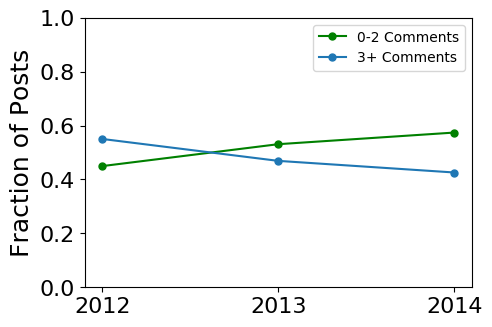

In [526]:
comment_category_0 = [10647, 23015, 3846]
comment_category_1 = [13032, 20331, 2853]
fix, ax = plt.subplots(figsize = (5,3.5))
num_comments_per_year = data_binned_2c.groupby(by=['created_year']).created_hour.count()
plt.plot([2012, 2013, 2014], comment_category_0 / num_comments_per_year, color='g', marker='.', markersize=10)
plt.plot([2012, 2013, 2014], comment_category_1 / num_comments_per_year, marker='.', markersize=10)
plt.ylim([0, 1])
ax.set_xticks([2012, 2013, 2014])
ax.set_ylabel('Fraction of Posts')
plt.legend(['0-2 Comments', '3+ Comments'])

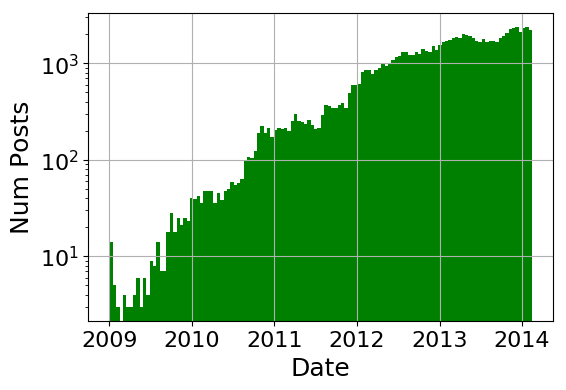

In [534]:
dates = pd.to_datetime(data_raw.created_utc, unit="s")

plt.subplots(1,1, figsize = (6,4))
dates.hist(bins=126, color='g')  # two bins per month
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Num Posts')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07ba6c7f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f07b7831940>], dtype=object)

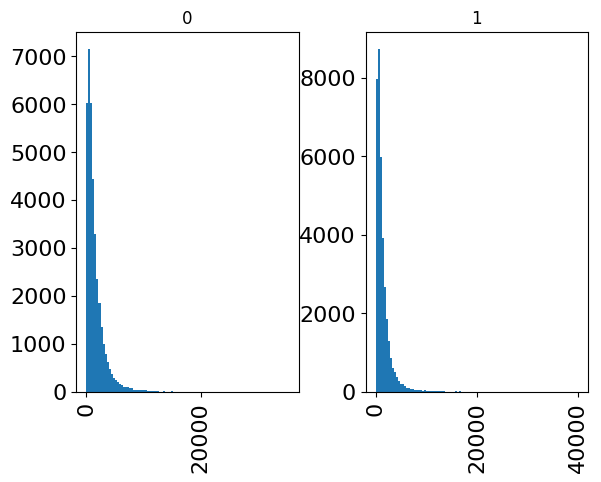

In [471]:
data_binned_2c.post_char_len.hist(by=data_binned_2c.comment_category, bins=100)

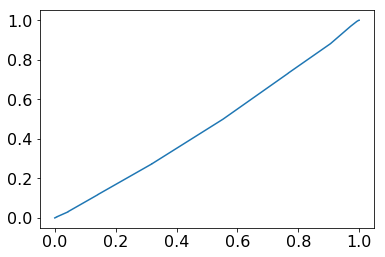

In [50]:
from sklearn import metrics
prob = model_binned_2b_ranfor.model.predict_proba(model_binned_2b_ranfor.test_x)
fpr, tpr, thresholds = metrics.roc_curve(model_binned_2b_ranfor.test_y, [x for (x,y) in prob])
plt.plot(fpr, tpr)

In [456]:
def SplitData(df, test_frac = 0.2) :
    " Quick function to divide dataframe into test and train sections"
    from sklearn.model_selection import train_test_split
    data_x = df.drop('comment_category', axis=1)
    data_y = df.comment_category
        
    (train_x, test_x, train_y, test_y) = train_test_split(
                    data_x, data_y, test_size = test_frac)
    return (train_x, test_x, train_y, test_y)

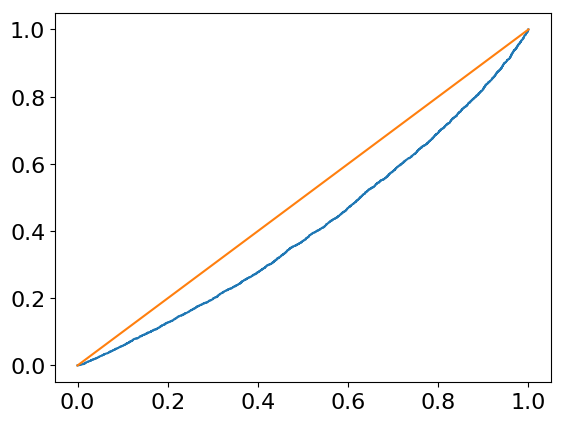

In [461]:
from sklearn import metrics
(train_x, test_x, train_y, test_y) = SplitData(data_binned_2c, 0.2)
model_2c_roc = model_2c
model_2c_roc.fit(train_x, train_y)
prob = model_2c_roc.predict_proba(test_x)
fpr, tpr, thresholds = metrics.roc_curve(test_y, [x for (x,y) in prob])
plt.plot(fpr, tpr, [0,1], [0,1])

In [460]:
prob

array([[ 0.51304816,  0.48695184],
       [ 0.49967806,  0.50032194],
       [ 0.49753106,  0.50246894],
       ..., 
       [ 0.53613892,  0.46386108],
       [ 0.51169317,  0.48830683],
       [ 0.5167697 ,  0.4832303 ]])

In [75]:
import matplotlib.pyplot as plt
plt.style.use('presentation')

OSError: 'presentation' not found in the style library and input is not a valid URL or path. See `style.available` for list of available styles.

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import matplotlib
matplotlib.get_configdir()

'/home/tobiszuts/.config/matplotlib'

In [67]:
sorted(plt.style.available)

['_classic_test',
 'bmh',
 'classic',
 'dark_background',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid']

In [104]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [125]:
import math
math.log10(311)/math.log10(1.2)

31.481701961693393

In [167]:
data_clean3.num_comments[data_clean.num_comments<2].count()

8016

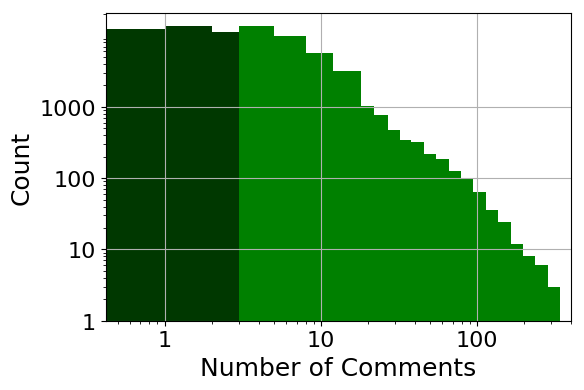

In [561]:
bins = [0, 1, 2, 3, 5, 8, 12] + [round(1.2**x) for x in range(16,33)]
fig, ax = plt.subplots()
#data_clean3.num_comments.hist(bins=bins, figsize=(6,4), color='#208000')
data_clean3.num_comments.hist(bins=bins, figsize=(6,4), color='#008000')

temp =  data_clean3.num_comments[data_clean3.num_comments<3]
temp.hist(bins=bins, figsize=(6,4), color='#003800')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('Number of Comments')
plt.xlim([0.42, 400])
ax.set_xticklabels([1, 10, 100])
ax.set_xticks([1, 10, 100])
ax.set_yticks([1, 10, 100, 1000])
ax.set_yticklabels([1, 10, 100, 1000])

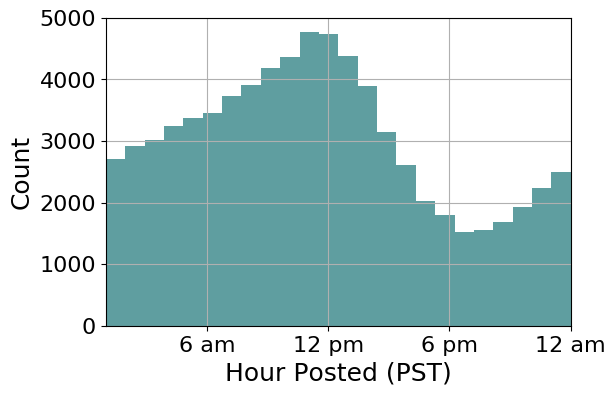

In [568]:
hour_display = (data_clean3.created_hour + 7) % 24 + 1
fig, ax = plt.subplots()
hour_display.hist(bins=24, figsize=(6,4), color="cadetblue")
plt.xlabel('Hour Posted (PST)')
plt.ylabel('Count')
plt.xlim([1, 24])
ax.set_xticks([6, 12, 18, 24])
ax.set_xticklabels(['6 am', '12 pm', '6 pm', '12 am'])

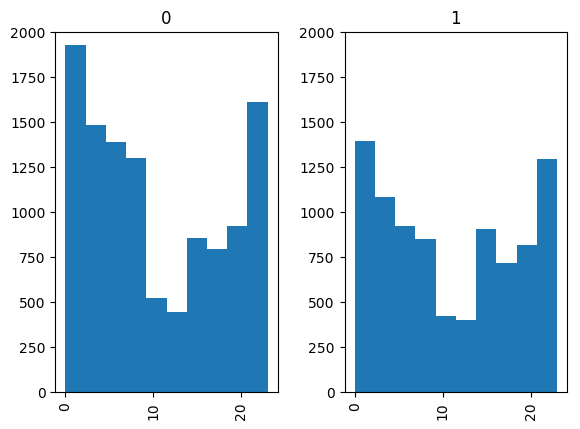

In [101]:
plt.style.use('default')
#data_binned.comment_category.hist(by=data_binned.created_hour)
ct = data_binned_2b.created_hour.hist(by=data_binned_2b.comment_category)
for x in ct :
    #for y in x :
        x.set_ylim([0, 2000])

In [53]:
ct

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07ca37a320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f07ca39d5c0>], dtype=object)

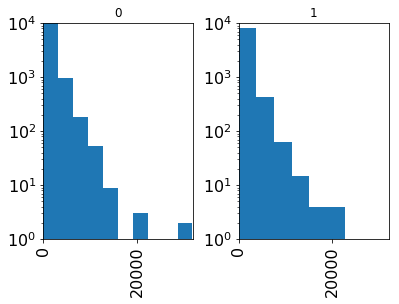

In [56]:
ct = data_binned_2b.post_char_len.hist(by=data_binned_2b.comment_category)
for y in ct :
    y.set_yscale('log')
    y.set_ylim([0, 10**4])
    y.set_xlim([0, 32000])

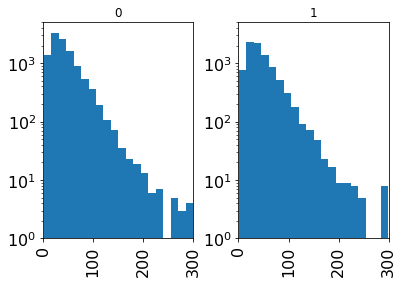

In [57]:
ct = data_binned_2b.title_char_len.hist(by=data_binned_2b.comment_category, bins=20)
for y in ct :
    y.set_yscale('log')
    y.set_ylim([0, 5*10**3])
    y.set_xlim([0, 300])

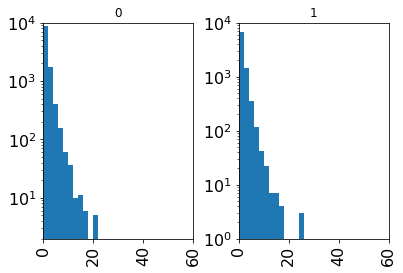

In [59]:
ct = data_binned_2b.post_num_qs.hist(by=data_binned_2b.comment_category, bins=range(0, 30, 2))
for y in ct :
    y.set_yscale('log')
    y.set_ylim([0, 10000])
    y.set_xlim([0, 60])

In [58]:
def plot_dataframe_histograms(df, groupby = None, legend_text = None, num_cols = 3) :
    """ Plot all columns of dataframe as a grid of histograms
        grouped by class (if given)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    num_plots = len(df.columns)
    fig, axes = plt.subplots(int(np.ceil(num_plots/num_cols)), num_cols, figsize = (14, 10))
    plt.subplots_adjust(hspace=0.4)
    
    plot_index = 0
    titles = df.columns
    for x in axes :
        for y in x :
            if plot_index >= len(titles) :
                fig.delaxes(y)
            else :
                col = titles[plot_index]
                bin_min = df[col].min()
                bin_max = df[col].max()
                bins = np.linspace(bin_min, bin_max, 10)
                df.groupby(groupby)[col].hist(alpha = 0.5, ax = y, bins = bins)
                y.set_yscale('log')
                y.set_xlabel(col)
                y.set_ylim(bottom = 1)
            plot_index += 1

    if legend_text :
        axes[0][0].legend(legend_text, loc='lower center')
    axes[0][0].set_ylabel('Count');
    return (fig, axes)

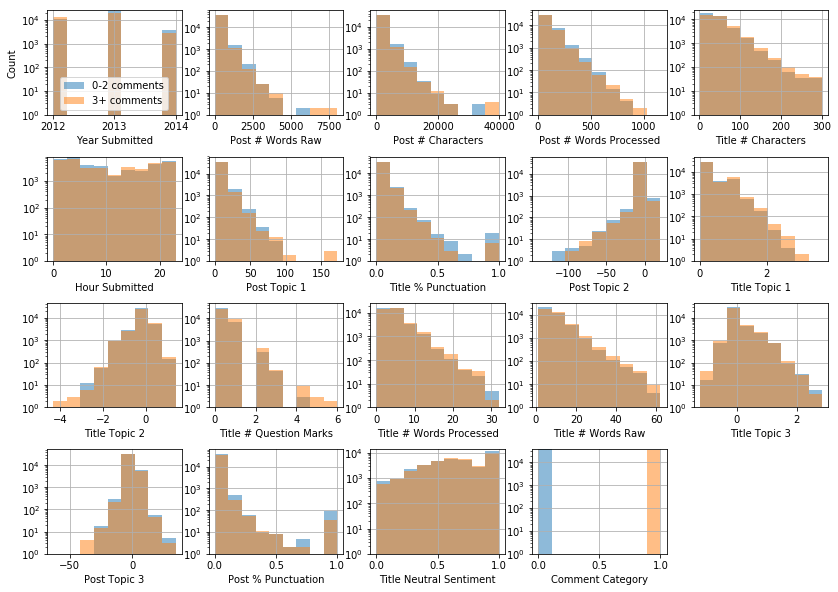

In [63]:
cols = ['created_year', 'post_word_len1', 'post_char_len', 'post_word_len2', 'title_char_len',
        'created_hour', 'post_lsi_0', 'title_perc_punc', 'post_lsi_1', 'title_lsi_0',
        'title_lsi_1', 'title_num_qs', 'title_word_len2', 'title_word_len1', 'title_lsi_2',
        'post_lsi_2', 'post_perc_punc', 'title_neu', 'comment_category']
labels = ['Year Submitted', 'Post # Words Raw', 'Post # Characters', 'Post # Words Processed',
          'Title # Characters', 'Hour Submitted', 'Post Topic 1', 'Title % Punctuation', 
          'Post Topic 2', 'Title Topic 1', 'Title Topic 2', 'Title # Question Marks', 
          'Title # Words Processed', 'Title # Words Raw', 'Title Topic 3', 'Post Topic 3', 
          'Post % Punctuation', 'Title Neutral Sentiment', 'Comment Category', '']
(fig, axes) = plot_dataframe_histograms(data_clean2[cols], 'comment_category', 
                          ['0-2 comments', '3+ comments'], num_cols = 5)
i = 0
for x in axes :
    for y in x :
        y.set_xlabel(labels[i])
        i += 1
#fig.delaxes(axes[-1][-2])

# Learning Rates

Plot learning curve, to see if the results are getting better with more data.  [This code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) taken from sklearn documentation.

In [324]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Learning rate shows that more data does not solve this problem: it's basically flat across here.  In other words, a hard problem.  This was also flat for 4 bins.

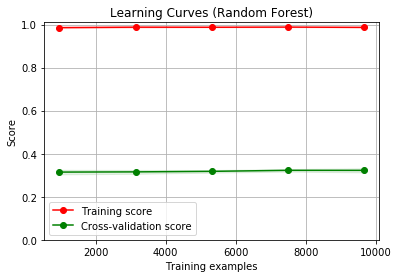

In [331]:
from sklearn import ensemble

data_new2 = data_new[data_new.num_posts_so_far < 1]
(train_x, train_y) = CreateTrainingData(data_new)

title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = ensemble.RandomForestClassifier()
plot_learning_curve(estimator, title, train_x, train_y, ylim=(0, 1.01), 
                    cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.show()

# Find similar posts

Use Gensim's similarity functions.

In [256]:
print(title_lsi)

LsiModel(num_terms=11384, num_topics=200, decay=1.0, chunksize=20000)


In [261]:
title_lsi_cols = ['title_lsi_{}'.format(x) for x in range(200)]
titles_lsi = data_binned_2b[title_lsi_cols].values.tolist()
titles_lsi[:5]

[[0.5785131574720587,
  -1.177367551373925,
  -0.24949794500964323,
  0.121289842332168,
  0.13659071272228046,
  0.04324562778068901,
  -0.02533537383338869,
  -0.0061817808872392304,
  -0.17238827250838604,
  -0.115089747341276,
  0.42468385999277325,
  -0.021990645995110074,
  0.11719692790906522,
  0.014128482842948858,
  -0.007348949947318814,
  -0.09728658412117523,
  -0.02482052043051917,
  -0.032922765212740665,
  0.03536975109248995,
  -0.06033026013734706,
  0.05092037643179068,
  0.06728478497946858,
  -0.0635894204002583,
  -0.02376727633300331,
  0.19346592015405106,
  0.4876901266676087,
  -0.1859047000302133,
  0.645327286797388,
  0.20007514910346597,
  0.05839176648857604,
  0.10175022145021764,
  0.06318149334721271,
  -0.038686062464712165,
  -0.0296264352612831,
  -0.15725083683816835,
  -0.19670068794970597,
  0.129547564611303,
  -0.019589454131283598,
  0.049192237148360074,
  0.011356695888358359,
  -0.10744171493880326,
  -0.07268753571696192,
  -0.039862980174

In [268]:
titles_vec = Vectorize_text(titles_tokenized, dictionary)

In [270]:
from gensim import similarities
title_index = similarities.MatrixSimilarity(title_lsi[titles_vec])

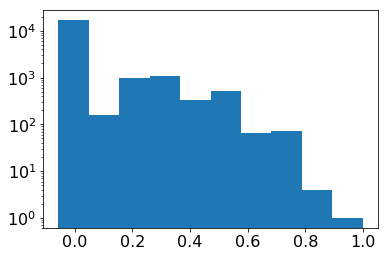

In [278]:
plt.hist(title_index[title_index.index[0]])
plt.yscale('log')

In [280]:
titles_tokenized[0]

['i', 'feel', 'like', 'brain', 'work', 'anymor']

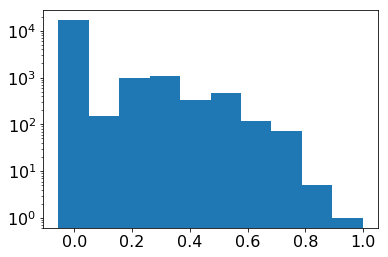

In [324]:
test = ['i', 'feel', 'like', 'work', 'anymor']
test_vec = Vectorize_text([test], dictionary)
test_lsi = title_lsi[test_vec[0]]
results = title_index[test_lsi]
plt.hist(results)
plt.yscale('log')
#results.shape

In [328]:
sorted(results, reverse=True)[:5]

array([  9.98480201e-01,  -1.60365086e-03,  -1.45785511e-04,
        -1.61932688e-03,  -2.21026447e-02], dtype=float32)

In [547]:
def FindSimilarTexts(text, dictionary, lsi, sim_index, sort_output = True) :
    """ Find the index of the most similar texts in the corpus.  
        Returns a list of tuples, where each element is (index, similarity score).
    """
    
    text_tokenized = ProcessText([text])
    print(text_tokenized)
    text_vec = Vectorize_text(text_tokenized, dictionary)
    text_lsi = lsi[text_vec[0]]
    results = sim_index[text_lsi]
    
    results2 = [(x, y) for (x, y) in enumerate(results)]
    if sort_output :
        results2 = sorted(results2, key=lambda x: x[1], reverse = True)
        
    return results2

In [382]:
test = "I don't feel like I can control my work anymore"
closest = FindSimilarTexts(test, dictionary, title_lsi, title_index)
for x in range(10) :
    print(closest[x][0], ':\t', closest[x][1], titles_tokenized[closest[x][0]])

[['i', 'feel', 'like', 'i', 'control', 'work', 'anymor']]
0 :	 0.996273 ['i', 'feel', 'like', 'brain', 'work', 'anymor']
17599 :	 0.870139 ['i', 'feel', 'like', 'i', 'control', 'anymor']
1422 :	 0.864823 ['work', 'feel', 'like', 'imposs']
19148 :	 0.863975 ['i', 'feel', 'like', 'i', 'anymor']
19958 :	 0.812379 ['i', 'dont', 'feel', 'like', 'anymor']
16333 :	 0.791365 ['i', 'cant', 'stand', 'anymor', 'i', 'feel', 'like', 'wall', 'dark', 'close']
8680 :	 0.761634 ['second', 'week', 'take', 'lexapro', 'work', 'i', 'feel', 'like', 'i', 'person', 'anymor']
4264 :	 0.758829 ['bore', 'work', 'feel', 'like', 'write']
6296 :	 0.748104 ['i', 'feel', 'like', 'burden', 'i', 'know', 'anymor']
14320 :	 0.747855 ['too', 'depress', 'work', 'i', 'feel', 'like', 'failur']


Create database of best posts.

In [361]:
data_clean3.head()

,created_dayofweek,created_hour,created_month,created_year,num_comments,post_char_len,post_compound,post_neg,post_neu,post_num_punc,...,title_lsi_190,title_lsi_191,title_lsi_192,title_lsi_193,title_lsi_194,title_lsi_195,title_lsi_196,title_lsi_197,title_lsi_198,title_lsi_199
0,4,14,2,2014,0,747,-0.9712,0.207,0.769,34,...,-0.008527,0.012735,0.010116,0.043001,0.028728,-0.024273,-0.014302,-0.012707,-0.011390,0.007423
1,4,14,2,2014,0,789,0.9900,0.125,0.559,43,...,0.051030,-0.014727,0.136306,-0.029079,-0.137306,-0.100882,0.035443,0.010597,-0.004723,-0.203823
2,4,14,2,2014,1,771,0.9226,0.152,0.630,25,...,0.003280,0.011811,0.001370,0.001369,-0.003967,-0.018174,-0.008690,0.018803,-0.001124,0.014185
3,4,13,2,2014,0,337,-0.7227,0.119,0.853,19,...,-0.046398,-0.019397,-0.030260,0.016207,0.038746,0.003811,0.002787,0.027037,-0.016794,-0.029016
4,4,12,2,2014,0,671,-0.9501,0.308,0.539,0,...,0.013346,-0.018291,0.028742,0.018196,0.008783,0.006742,-0.021630,-0.001128,0.002138,-0.045949


In [540]:
data_similarity = data_clean3.copy()
data_similarity = data_similarity.join([data_clean.title, data_clean.selftext, data_raw.id])
similarity_columns = ['title', 'selftext', 'id', 'num_comments']
similarity_columns += ['title_lsi_{}'.format(x) for x in range(50)]
similarity_columns += ['post_lsi_{}'.format(x) for x in range(50)]
data_similarity = data_similarity[similarity_columns]
data_similarity.head()

,title,selftext,id,num_comments,title_lsi_0,title_lsi_1,title_lsi_2,title_lsi_3,title_lsi_4,title_lsi_5,...,post_lsi_40,post_lsi_41,post_lsi_42,post_lsi_43,post_lsi_44,post_lsi_45,post_lsi_46,post_lsi_47,post_lsi_48,post_lsi_49
0,I feel like my brain doesn't work anymore.,"I can't think straight, I can't concentrate, I...",1xwb9u,0,0.517205,-1.175974,-0.299707,-0.155425,0.049635,-0.141862,...,-0.412346,-0.318944,-0.482247,-0.113933,0.827982,0.198084,0.281417,1.293658,0.536218,-0.201752
1,She's the girl i was always looking for... But...,There is this amazing girl that i've known sin...,1xwaio,0,0.086153,-0.036486,0.027594,0.094607,-0.025899,0.048370,...,0.824453,1.110590,0.014197,0.381482,-0.276160,-1.059694,0.823603,0.531138,0.266104,0.492577
2,I don't have anyone and I don't know why,I've been struggling with depression since hig...,1xwah3,1,0.186916,-0.108239,0.110488,0.631919,0.307536,-0.566235,...,0.579967,0.788790,0.360581,-0.306364,-0.533368,-0.922997,0.176328,-0.252666,0.017663,0.384147
3,how often do you guys inflict self harm?,i burn myself..... i heat up a knife and hold ...,1xw6ra,0,0.036970,-0.008365,0.025421,0.019800,-0.002955,0.008240,...,-0.013148,0.039785,-0.023179,0.212562,-0.048190,-0.005015,0.101565,-0.164543,0.099288,0.093257
4,All I do is hide,I’m scared\n Of myself\n ...,1xw4bo,0,0.003941,-0.002300,0.000648,0.006746,0.000231,0.003020,...,-0.184916,0.997697,-1.793905,0.742097,-0.590438,-0.201007,0.800539,-0.878893,0.710075,1.545719


22494


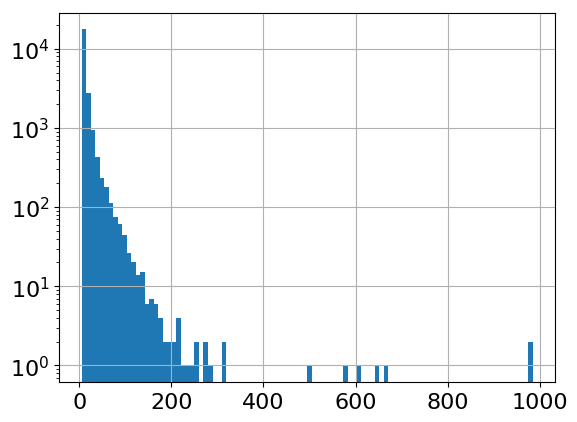

In [541]:
data_similarity = data_similarity[data_similarity.num_comments > 4]
print(len(data_similarity))
data_similarity.num_comments.hist(bins=100)
plt.yscale('log')

In [543]:
def CreateSimilarityMatrix(df, dictionary, title_lsi, post_lsi) :
    """ Create index for finding most similar texts.
    """
    from gensim import similarities
    
    titles_tokenized = ProcessText(df.title)
    titles_vec = Vectorize_text(titles_tokenized, dictionary)
    titles_lsi = title_lsi[titles_vec]
    titles_index = similarities.MatrixSimilarity(titles_lsi)
        
    posts_tokenized = ProcessText(df.selftext)
    posts_vec = Vectorize_text(posts_tokenized, dictionary)
    posts_lsi = post_lsi[posts_vec]
    posts_index = similarities.MatrixSimilarity(posts_lsi)
    
    return titles_index, posts_index

In [544]:
my_timer = SimpleTimer()
(titles_index, posts_index) = CreateSimilarityMatrix(data_similarity, dictionary, title_lsi, post_lsi)
my_timer.elapsed()

--- 54.59461212158203 s ---


Could weight title and post several different ways.  Equal, but note that titles are short enough that they have a higher chance of getting a good match (+20% greater).  So weight post double that of title.  Could also take geometric mean, which might be the best way to find one that works for both, but would need to control for negative numbers there...too much hassle.

In [545]:
def FindSimilarPosts(post_title, post_text, dictionary, title_lsi, post_lsi, titles_index, posts_index) :
    """ Find most similar posts by taking a simple average of the title and
        post similarity, and taking the top one
    """
    
    title_best = FindSimilarTexts(post_title, dictionary, title_lsi, titles_index, sort_output = False)
    post_best = FindSimilarTexts(post_text, dictionary, post_lsi, posts_index, sort_output = False)
    
    compound_best = [(i, (x+2*y)/3) for ((i, x), (j, y)) in zip(title_best, post_best)]
    compound_best = sorted(compound_best, key = lambda x: x[1], reverse = True )
    
    return compound_best, title_best, post_best

In [548]:
test_title = "I don't feel like I can control my work anymore"
test_post = "I'm in college, and that's a joke; I failed most of my classes last semester, and I'm on the verge of failing the 2 I'm taking this semester. I decided to go to school only half time this semester, and I can't even do that. And it's only community college - who fails community college? I want to drop out. "
(compound_best, title_best, post_best) = FindSimilarPosts(test_title, test_post, dictionary, title_lsi, post_lsi, titles_index, posts_index)

[['i', 'feel', 'like', 'i', 'control', 'work', 'anymor']]
[['i', 'colleg', 'joke', 'i', 'fail', 'class', 'last', 'semest', 'i', 'verg', 'fail', '2', 'i', 'take', 'semest', 'i', 'decid', 'go', 'school', 'half', 'time', 'semest', 'i', 'even', 'and', 'communiti', 'colleg', 'fail', 'communiti', 'colleg', 'i', 'want', 'drop']]


In [395]:
for x in range(5) :
    print(compound_best[x], title_best[x], post_best[x])

(0, 0.14120428264141083) (0, 0.18945965) (0, 0.092948906)
(1, 0.024312647059559822) (1, -0.020702135) (1, 0.069327429)
(2, 0.036876130849123001) (2, -0.0027760509) (2, 0.076528311)
(3, 0.078402318060398102) (3, 0.001336813) (3, 0.15546782)
(4, 0.017794430255889893) (4, 0.0020439122) (4, 0.03354495)


In [403]:
all_best = []
for (x, y, z) in zip (compound_best, title_best, post_best) :
    all_best.append((x, y, z))
    
sorted(all_best, key=lambda x: x[0][1], reverse=True)[:10]

[((4873, 0.47967983285586041), (4873, 0.36767653), (4873, 0.53568149)),
 ((2309, 0.43878937760988873), (2309, 0.47476771), (2309, 0.42080021)),
 ((583, 0.42458458741505939), (583, 0.72543395), (583, 0.27415991)),
 ((2004, 0.41706311454375583), (2004, 0.0018707439), (2004, 0.6246593)),
 ((2385, 0.39850888649622601), (2385, 0.49257201), (2385, 0.35147732)),
 ((1565, 0.38615229725837708), (1565, 0.70148653), (1565, 0.22848518)),
 ((816, 0.38549792766571045), (816, 0.70416903), (816, 0.22616237)),
 ((4339, 0.38001102209091187), (4339, 0.57672048), (4339, 0.2816563)),
 ((3982, 0.37906434138615924), (3982, 0.57198608), (3982, 0.28260347)),
 ((664, 0.37865559260050458), (664, 0.70332682), (664, 0.21631998))]

In [410]:
sorted(post_best, key=lambda x: x[1], reverse=True)[:10]

[(2004, 0.6246593),
 (4873, 0.53568149),
 (4930, 0.52052206),
 (3633, 0.51595342),
 (2532, 0.50589722),
 (2206, 0.48552975),
 (2390, 0.48186624),
 (3443, 0.47633302),
 (3044, 0.47292316),
 (2727, 0.47091252)]

In [549]:
def SaveSimilarityVariables(base_name, titles_index, posts_index, df_sim) :
    """ Save variables to disk with pickle
    """
    import pickle
        
    file_name = '{}_titles_index.p'.format(base_name)
    pickle.dump(titles_index, open(file_name, 'wb'))
    
    file_name = '{}_posts_index.p'.format(base_name)
    pickle.dump(posts_index, open(file_name, 'wb'))
    
    file_name = '{}_df.p'.format(base_name)
    pickle.dump(df_sim, open(file_name, 'wb'))
    
    return

In [550]:
SaveSimilarityVariables('Similarity2', titles_index, posts_index, data_similarity)

In [558]:
for x in range(5) :
    temp = data_clean[data_clean3.num_comments>4].iloc[x]
    print(temp.num_comments, temp.created_year, temp.title, '\n\t', temp.selftext, '\n')

7 2014 Ever feel happy and content but then you just get really sad after for no reason? 
	 When I hang out with friends I'm laughing and having fun and even sometimes I feel happy. As soon as I leave to go home I get overwhelmed with a feeling of sadness. I almost want to say that it matches the level of happiness I feel. I was just curious if this is a sign of depression because I've read a lot about depression and I am seeing a therapist but he never said to me directly that I am depressed.   

9 2014 Anybody? 
	 I'm awake, for now. Let's talk... I just want someone to talk to...  

7 2014 How to support someone who has depression? 
	 My girlfriend is diagnosed with depression and has been for almost a year. Almost every time we see each other she mentions her depression. Usually it's about how happy she was before or how her doctor upped her medication dosage. I'm generally a happy person that doesn't really understand depression so I never know what to say or how to react. 

My fi